# Отток клиентов

Необходимо спрогнозировать, уйдёт клиент из банка в ближайшее время или нет на основании исторических данные о поведении клиентов и расторжении договоров с банком. 

<b>Цель:</b> Обучить модель, которая сможет спрогнозировать уйдет ли клиент в ближайшее время или нет<br>
<b>Задачи:</b><br>
    1. Подготовить датасет к анализу<br>
    2. Определить, есть ли дисбаланс классов<br>
    3. Обучить модели дерево решений, лес решений, логистическая регрессия без учета дисбаланса классов<br>
    4. обучить эти же модели, применяя различне методы борьбы с дисбалансом классов:<br>
       - взвешивание классов<br>
       - увеличение классов<br>
       - уменьшение классов<br>
    5. Найти лучшую модель с f1 не менее 0,59  и протестировать ее, сравнить с AUC-ROC

## Подготовка данных

Сделаем все необходимые импорты:

In [4]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, roc_curve, f1_score, roc_auc_score
from sklearn.utils import shuffle
import warnings
import matplotlib.pyplot as plt
RANDOM_STATE = 12345

Откроем файл и изучим его:

In [5]:
churn = pd.read_csv('/datasets/Churn.csv') #открываем файл
print(churn.info()) #выводим общую информацию
churn.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


Можно заметить, что в датасете есть нечисловые (object) столбцы: Surname, Geography, Gender. Преобразуем их в числовые методом OHE, так как он подходит и для деревьев решений, и для логистической регрессии. <br>
В исходном датасете есть также столбцы: RowNumber, CustomerId,Surname. Крайне сомнительно, что эти столбцы  могут оказать какое-то влияние на то, уйдет клиент или нет. По сути дела, они представляют собой просто уникальные идентификаторы и фамилии пользователей. А вот риски переобучения модели здесь могут повышаться<br>
Таким образом, я бы хотела построить и сравнить модели на двух возможных датасетах:
<li>полный датасет churn</li>
<li>датасет churn_wo_RN_CI - churn без столбцов CustomerId,RowNumber </li>

Можно также заметить, что в столбце Tenure (сколько лет человек является клиентом банка).  Рассмотрим, что это за пропущенные значения и есть ли необходмость каким-либо образом заполнять пропуски

In [6]:
display(churn.query('Tenure.isna() == True').head(10))
print()
print('Уникальные значения в столбце Tenure:')
print(churn['Tenure'].unique())
#Удалим пропущенные значения
churn = churn.dropna()
print('Уникальные значения в столбце Tenure после удаления:')
print(churn['Tenure'].unique())
print('Общая информация о таблице после преобразования:')
print(churn.info())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
82,83,15641732,Mills,543,France,Female,36,NaN,0.00,2,0,0,26019.59,0
85,86,15805254,Ndukaku,652,Spain,Female,75,NaN,0.00,2,1,1,114675.75,0
94,95,15676966,Capon,730,Spain,Male,42,NaN,0.00,2,0,1,85982.47,0
99,100,15633059,Fanucci,413,France,Male,34,NaN,0.00,2,0,0,6534.18,0
111,112,15665790,Rowntree,538,Germany,Male,39,NaN,108055.10,2,1,0,27231.26,0



Уникальные значения в столбце Tenure:
[ 2.  1.  8.  7.  4.  6.  3. 10.  5.  9.  0. nan]
Уникальные значения в столбце Tenure после удаления:
[ 2.  1.  8.  7.  4.  6.  3. 10.  5.  9.  0.]
Общая информация о таблице после преобразования:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 14 columns):
RowNumber          9091 non-null int64
CustomerId         9091 non-null int64
Surname            9091 non-null object
CreditScore        9091 non-null int64
Geography          9091 non-null object
Gender             9091 non-null object
Age                9091 non-null int64
Tenure             9091 non-null float64
Balance            9091 non-null float64
NumOfProducts      9091 non-null int64
HasCrCard          9091 non-null int64
IsActiveMember     9091 non-null int64
EstimatedSalary    9091 non-null float64
Exited             9091 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.0+ MB
None


Можно видеть, что пропуски в значениях достаточно случайны, сюда попали абсолютно разные клиенты банка, а также то, что в столбце Tenure содержатся уникальные значения от 0 до 10 лет. Для корректной работы модели нам необходимо, чтобы все значения были числовыми. Эти данные категориальные, их можно заменить только каким-то значением по умолчанию, и нулем оно быть уже не может, так как в списке уникальных значений уже есть 0. Любое числовое значение здесь может повлиять на результат, так что решено эти данные удалить. 

<b>Создадим дамми-признаки для столбцов с типом данных object</b>

In [7]:
def make_dummies_func(array, name): #Функция для создания дамми-признаков 
    dummy_array = pd.get_dummies(array, drop_first = True)
    print()
    print('Датасет с дамми-признаками: ',name)
    display(dummy_array.head(3))
    print('Размер датасета:', dummy_array.shape)
    return dummy_array

# Создадим дамми-признаки для датасета с полными даными:
churn_ohe = make_dummies_func(churn, 'Датасет на полных данных')
# Создадим дамми-признаки для датасета  без RowNumber, CustomerID, Surname, Surname:
churn_wo_RN_CI = make_dummies_func(churn.drop(['RowNumber','CustomerId','Surname'],axis = 1), 'Датасет на данных без RowNumber, CustomerID, Surname, Surname')
print()
print('Выведем уникальные значения в столбцах (для контроля корректности полученных дамми-признаков, а также определения необходимости стандартизации признаков):')
print('Уникальные значения в столбце Geography: ',churn['Geography'].unique())
print('Уникальные значения в столбце NumOfProducts: ',churn['NumOfProducts'].unique())
print('Уникальные значения в столбце HasCrCard: ',churn['HasCrCard'].unique())
print('Уникальные значения в столбце IsActiveMember: ',churn['IsActiveMember'].unique())


Датасет с дамми-признаками:  Датасет на полных данных


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Surname_Zotova,Surname_Zox,Surname_Zubarev,Surname_Zubareva,Surname_Zuev,Surname_Zuyev,Surname_Zuyeva,Geography_Germany,Geography_Spain,Gender_Male
0,1,15634602,619,42,2.0,0.00,1,1,1,101348.88,...,0,0,0,0,0,0,0,0,0,0
1,2,15647311,608,41,1.0,83807.86,1,0,1,112542.58,...,0,0,0,0,0,0,0,0,1,0
2,3,15619304,502,42,8.0,159660.80,3,1,0,113931.57,...,0,0,0,0,0,0,0,0,0,0


Размер датасета: (9091, 2800)

Датасет с дамми-признаками:  Датасет на данных без RowNumber, CustomerID, Surname, Surname


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0


Размер датасета: (9091, 12)

Выведем уникальные значения в столбцах (для контроля корректности полученных дамми-признаков, а также определения необходимости стандартизации признаков):
Уникальные значения в столбце Geography:  ['France' 'Spain' 'Germany']
Уникальные значения в столбце NumOfProducts:  [1 3 2 4]
Уникальные значения в столбце HasCrCard:  [1 0]
Уникальные значения в столбце IsActiveMember:  [1 0]


<b>Разделим датасеты на тренировочную, валидационную и тестовую выборки, стандартизируем признаки. </b><br>
Разобьем датасеты на тестовую, валидационную и тренировочную выборки. Выделим целевой столбец и признаки.<br>
Признаки имеют разный "масштаб".Для корректности работы модели (чтобы модель не считала некоторые признаки важнее остальных) проведем процедуру стандартизации этих признаков. 

In [8]:
# Функция для разбиения датасета на тренировочный, валидационный, тестовый и стандартизации признаков
def create_Standartize_features_target(array,target_column,numeric_columns,dataset_name):
    target = array[target_column]
    features = array.drop(target_column,axis = 1)
    #разбиваем на выборки: тренировочную, тестовую, валидационную
    features_,features_test,target_,target_test = train_test_split(features,target,test_size = 0.2, random_state = RANDOM_STATE)
    features_train,features_valid,target_train,target_valid = train_test_split(features_,target_,test_size = 0.25, random_state = RANDOM_STATE)
    #стандартизируем
    scaler = StandardScaler()
    scaler.fit(features_train[numeric_columns])
    features_train[numeric_columns] = scaler.transform(features_train[numeric_columns])
    features_valid[numeric_columns] = scaler.transform(features_valid[numeric_columns])
    features_test[numeric_columns] = scaler.transform(features_test[numeric_columns])
    print()
    print('Размеры выборок для датасета: ', dataset_name)
    print('Размер тренировочной выборки:', features_train.shape)
    print('Размер валидационной выборки:', features_valid.shape)
    print('Размер тестовой выборки:', features_test.shape)
    print('-------------------------------------------------')
    return features_train, target_train, features_valid, target_valid, features_test, target_test


warnings.simplefilter('ignore')
#Разобьем на выборки датасет на полных данных
churn_feat_train, churn_targ_train, churn_feat_valid, churn_targ_valid, churn_feat_test, churn_targ_test = create_Standartize_features_target(churn_ohe,'Exited',['RowNumber','CustomerId','CreditScore','Age','Tenure','Balance','EstimatedSalary', 'NumOfProducts'],'Датасет на полных данных')
#Разобьем на выборки датасет без RowNumber, CustomerID, Surname
churn_RnCi_feat_train, churn_RnCi_targ_train, churn_RnCi_feat_valid, churn_RnCi_targ_valid, churn_RnCi_feat_test, churn_RnCi_targ_test = create_Standartize_features_target(churn_wo_RN_CI,'Exited',['CreditScore','Age','Tenure','Balance','EstimatedSalary', 'NumOfProducts'],'Датасет без RowNumber, CustomerID, Surname')

#Выведем для наглядности полученных значений три строки churn_feat_train
print()
print('Пример churn_feat_train')
churn_feat_train.head(3)


Размеры выборок для датасета:  Датасет на полных данных
Размер тренировочной выборки: (5454, 2799)
Размер валидационной выборки: (1818, 2799)
Размер тестовой выборки: (1819, 2799)
-------------------------------------------------

Размеры выборок для датасета:  Датасет без RowNumber, CustomerID, Surname
Размер тренировочной выборки: (5454, 11)
Размер валидационной выборки: (1818, 11)
Размер тестовой выборки: (1819, 11)
-------------------------------------------------

Пример churn_feat_train


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Surname_Zotova,Surname_Zox,Surname_Zubarev,Surname_Zubareva,Surname_Zuev,Surname_Zuyev,Surname_Zuyeva,Geography_Germany,Geography_Spain,Gender_Male
3706,-0.443214,-0.471913,-0.203819,0.471273,0.352316,0.786022,0.782369,0,0,-0.357205,...,0,0,0,0,0,0,0,0,1,0
6805,0.630136,-1.588758,-0.357513,-0.384930,-1.373506,-1.230577,0.782369,1,1,-1.671048,...,0,0,0,0,0,0,0,0,0,0
4449,-0.185873,-1.709794,0.175290,-0.289797,-0.683177,-1.230577,0.782369,1,0,-1.119181,...,0,0,0,0,0,0,0,0,0,1


Данные разделены на выборки и стандртизированы: данные готовы к дальнейшему анализу. 
Произведем анализ по следующему алгоритму:
1. Проверим, есть ли в данных дисбаланс классов и какой он.
2. Исследуем следущие модели без учета дисбаланса классов: <br>
2.1. Дерево решений <br>
2.2. Лес решений <br>
2.3. Логистическая регрессия
3. Устраним дисбаланс классов методом взвешивания классов и исследуем эти же модели
4. Усстраним дисбаланс классов методом увеличения выборки и исследуем эти же модели
5. Устраним дисбаланс классов методом уменьшения выборки и исследуем эти же модели
6. Выберем наилучшую модель и проверим ее на тестовой выборке.<br>
Анализ проведем для обеих моделей.

## Исследование задачи

<h3>Исследование дисбаланса классов</h3>

Создадим функции для построения моделей

In [28]:
#Функция расчета и печати основных метрик 
def print_basic_metrics(target_valid, predicted_valid, model, features_valid):
    accuracy = accuracy_score(target_valid,predicted_valid)
    recall = recall_score(target_valid,predicted_valid)
    precision = precision_score(target_valid,predicted_valid)
    f1 = f1_score(target_valid,predicted_valid)
    conf_matrix = confusion_matrix(target_valid,predicted_valid)
    roc_auc = roc_auc_score(target_valid,predicted_valid)
    
    #Выводим на экран метрики, если это необходимо
    print('Значение меры accuracy = ',accuracy)
    print('Значение меры recall = ',recall)
    print('Значение меры precision = ',precision)
    print('Значение меры f1 = ',f1)
    print('Значение меры auc roc = ',roc_auc)
    print('Значение меры confusion matrix: ')
    print(conf_matrix)
    #выводим roc-кривую
    preds = model.predict_proba(features_valid)[::,1]
    # = probs[:,1]
    fpr, tpr, thresholds = roc_curve(target_valid,preds)
    plt.plot(fpr, tpr,marker ='.' ,label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0,1],[0,1],linestyle = "--")
    
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC-Кривая')
    plt.show()
    return accuracy, recall, precision, f1, conf_matrix, roc_auc

#Функция для создания модели дерева решений и расчета метрик
def make_DecisionTree_model(features_train,target_train,features_valid, target_valid, depth, metrics_print,cls_weight):
    #Создаем модель Дерево решений
    if depth == None:
        model = DecisionTreeClassifier(random_state = RANDOM_STATE, class_weight = cls_weight)
    else:
        model = DecisionTreeClassifier(max_depth = depth, random_state = RANDOM_STATE, class_weight = cls_weight)
    #Обучаем модель и делаем предсказание    
    model.fit(features_train,target_train)
    predicted_valid = model.predict(features_valid)
    #Рассчитываем метрики
    if metrics_print == True:
        count_basic_metrics(target_valid, predicted_valid, metrics_print)
    return model, predicted_valid

def make_DecisionForest_model(features_train,target_train,features_valid, target_valid, estimators ,depth, metrics_print, cls_weight):
    #Строим модель
    model = RandomForestClassifier(n_estimators = estimators, max_depth = depth, random_state = RANDOM_STATE, class_weight = cls_weight)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    #Рассчитываем метрики
    if metrics_print == True:
        count_basic_metrics(target_valid, predicted_valid, metrics_print)
    return model, predicted_valid

def make_LogisticRegression_model(features_train,target_train,features_valid, target_valid, metrics_print, cls_weight):
    #Строим модель
    model = LogisticRegression(random_state = RANDOM_STATE, solver = 'liblinear', class_weight = cls_weight)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    #Рассчитываем метрики
    if metrics_print == True:
        count_basic_metrics(target_valid, predicted_valid, metrics_print)
    return model, predicted_valid


#Функция для расчета accuracy модели со 100% нулевым предсказанием 
def find_accuracy_zero_model(target, goal_const):
    target_pred_const = pd.Series([goal_const] * len(target))
    print('Значение accuracy со 100% предсказанием значения ',goal_const,' = ',accuracy_score(target,target_pred_const))
    


<b>Проверим, есть ли дисбаланс классов:</b>

In [10]:
#Для начала посмотрим, насколько сильный дисбаланс классов наблюдается в исходном датасете:
print('Доля значений каждого класса в исходном датафрейме:')
print(churn['Exited'].value_counts(normalize = True))
print()
print('Доля значений каждого класса в обучающей выборке:')
print(churn_targ_train.value_counts(normalize = True))
print()
print('Доля значений каждого класса в тренировочной выборке:')
print(churn_targ_valid.value_counts(normalize = True))
print()
print('Доля значений каждого класса в тестовой выборке:')
print(churn_targ_test.value_counts(normalize = True))

Доля значений каждого класса в исходном датафрейме:
0    0.796062
1    0.203938
Name: Exited, dtype: float64

Доля значений каждого класса в обучающей выборке:
0    0.794829
1    0.205171
Name: Exited, dtype: float64

Доля значений каждого класса в тренировочной выборке:
0    0.79868
1    0.20132
Name: Exited, dtype: float64

Доля значений каждого класса в тестовой выборке:
0    0.797141
1    0.202859
Name: Exited, dtype: float64


Как можно видеть, наблюдается явный дисбаланс классов: доля нулевого класса около 80%, а единичного - 20%.<br>
Исследуем модели без учета дисбаланса классов. Ввиду того, что для модели с таким большим дисбалансом классов будет характерно высокое значение accuracy даже при полностью "нулевом" прогнозе (значение этого прогноза выведено ниже), то данную метрику не стоит считать целевой. Для того, чтобы максимально полно оценить качество модели, возбмем в качестве целевой меру f1: она позволяет одновременно контролировать и полноту, и точность

<h3>Построение моделей без учета дисбаланса классов</h3>

<h4>Дерево решений:</h4>

-------------------------------------------------------
Исследование модели Дерево решений на полных данных (без учета дисбаланса классов):

Значение accuracy со 100% предсказанием значения  0  =  0.7986798679867987
Значение меры accuracy =  0.8514851485148515
Значение меры recall =  0.4918032786885246
Значение меры precision =  0.6818181818181818
Значение меры f1 =  0.5714285714285714
Значение меры auc roc =  0.7169760195095516
Значение меры confusion matrix: 
[[1368   84]
 [ 186  180]]


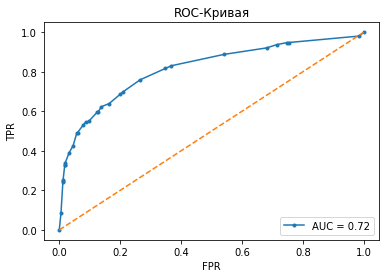



-------------------------------------------------------
Исследование модели Дерево решений на данных без RowNumber, CustomerID, Surname (без учета дисбаланса классов):

Значение accuracy со 100% предсказанием значения  0  =  0.7986798679867987
Значение меры accuracy =  0.841034103410341
Значение меры recall =  0.4972677595628415
Значение меры precision =  0.6341463414634146
Значение меры f1 =  0.557427258805513
Значение меры auc roc =  0.7124768549880323
Значение меры confusion matrix: 
[[1347  105]
 [ 184  182]]


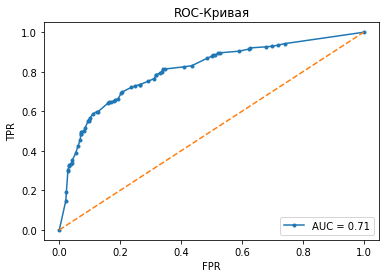

In [29]:
#Функция для нахождения наилучшего дерева решений
def find_best_DecisionTree(features_train, target_train, features_valid, target_valid, cls_weight):
    best_depth = 0
    best_f1 = 0
    #для поиска наилучшего решения найдем значние целевой метрики при max_depth = None
    model_None, predict_None = make_DecisionTree_model(features_train, target_train, features_valid, target_valid, None, False, cls_weight)
    f1_none = f1_score(target_valid,predict_None)
    #Найдем наилучшую глубину для дерева решений, максимизируя целевую метрику
    for depth in range (1,20):
        model, predicted_values = make_DecisionTree_model(features_train, target_train, features_valid, target_valid, depth, False, cls_weight)
        f1 = f1_score(churn_targ_valid,predicted_values)
        if f1 > best_f1:
            best_f1 = f1
            best_depth = depth
            best_model = model
            best_predicted = predicted_values
    #сравним полученную "лучшую" модель с моделью, где max_depth = None
    if f1_none > best_f1:
        best_f1 = f1_none
        best_model = model_None
        best_predicted = predicted_values
    #выведим значения метрик для наилучшей модели    
    print_basic_metrics(target_valid, best_predicted, best_model, features_valid)
    return best_model, best_predicted
    
#Найдем наилучшее "дерево решений" для модели на полных данных и модели без RowNumber, CustomerID, Surname и 
#и выведем метрики для наилучших моделей
    
print('-------------------------------------------------------')
print('Исследование модели Дерево решений на полных данных (без учета дисбаланса классов):')  
print()
find_accuracy_zero_model(churn_targ_valid,0)    
DecTreeChurn_HO, predict_DecTree_HO = find_best_DecisionTree(churn_feat_train, churn_targ_train, churn_feat_valid, churn_targ_valid, None)
print()
print()

print('-------------------------------------------------------')
print('Исследование модели Дерево решений на данных без RowNumber, CustomerID, Surname (без учета дисбаланса классов):')    
print()
find_accuracy_zero_model(churn_targ_valid,0)    
DecTreeChurn_RnCi_HO, predict_RnCi_HO = find_best_DecisionTree(churn_RnCi_feat_train, churn_RnCi_targ_train, churn_RnCi_feat_valid, churn_RnCi_targ_valid, None)
print()
print()


На модели "дерево решений" удалось добиться значения меры f1 0.571 и 0.557 для модели на полных данных и моедли без RowNumber, CustomerID, Surname соответственно. Можно видеть, однако, что модель пропускает более 50% положительных ответов (значение меры recall ниже 0.5), что говорит все-таки о довольно низком качестве модели, хотя значение меры auc_roc значительно выше 0.5 то есть модель все-таки лучше случайной. Значения практически всех метрик для модели на полных данных выше, чем для модели без RowNumber, CustomerID, Surname

<h4>Лес решений:</h4>

-------------------------------------------------------
Исследование модели Лес решений на полных данных (без учета дисбаланса классов):

Значение accuracy со 100% предсказанием значения  0  =  0.7986798679867987
Наилучшее значение n_estimators =  18
Наилучшее значение max_depth =  69
Значение меры accuracy =  0.8476347634763476
Значение меры recall =  0.3087431693989071
Значение меры precision =  0.8248175182481752
Значение меры f1 =  0.44930417495029823
Значение меры auc roc =  0.6461071218895362
Значение меры confusion matrix: 
[[1428   24]
 [ 253  113]]


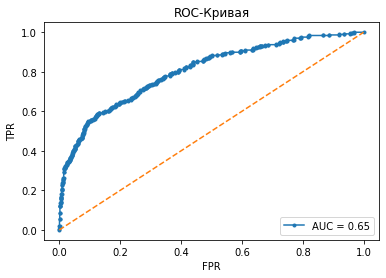



-------------------------------------------------------
Исследование модели Лес решений на данных без RowNumber, CustomerID, Surname, Surname (без учета дисбаланса классов):

Значение accuracy со 100% предсказанием значения  0  =  0.7986798679867987
Наилучшее значение n_estimators =  37
Наилучшее значение max_depth =  14
Значение меры accuracy =  0.8624862486248625
Значение меры recall =  0.43989071038251365
Значение меры precision =  0.7815533980582524
Значение меры f1 =  0.5629370629370629
Значение меры auc roc =  0.7044494874226618
Значение меры confusion matrix: 
[[1407   45]
 [ 205  161]]


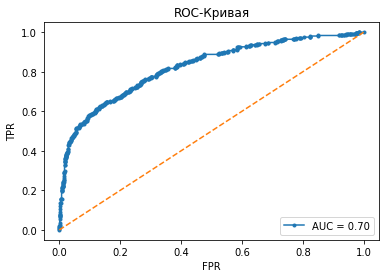

In [12]:
#функция для нахождения наилучшего Леса решений
def find_best_Forest(features_train, target_train, features_valid, target_valid, cls_weight):
    best_depth = 0
    best_metric = 0
    #для начала найдем наилучшее значение max_depth при небольшом значении n_estimators
    for depth in range(1,80):
        model, predicted_values = make_DecisionForest_model(features_train,target_train,features_valid, target_valid, 20 ,depth, False, cls_weight)
        metric = f1_score(target_valid,predicted_values)
        if metric > best_metric:
            best_metric = metric
            best_depth = depth
    best_estim = 0 
    best_metric = 0
    #найдем наилучшее n_estimators при найденном max_depth
    for estim in range(10,170,1):
        model, predicted_values = make_DecisionForest_model(features_train,target_train,features_valid, target_valid, estim ,best_depth, False, cls_weight)
        metric = f1_score(target_valid,predicted_values)
        if metric > best_metric:
            best_metric = metric
            best_estim = estim
            best_model = model
            best_predicted = predicted_values
    #выводим полученные значения гиперпараметров и полученные значения метрик
    print('Наилучшее значение n_estimators = ', best_estim)
    print('Наилучшее значение max_depth = ', best_depth)
    print_basic_metrics(target_valid, best_predicted, best_model, features_valid)
    return best_model, best_predicted        

print('-------------------------------------------------------')
print('Исследование модели Лес решений на полных данных (без учета дисбаланса классов):')  
print()
find_accuracy_zero_model(churn_targ_valid,0)    
ForestChurn_HO, predict_Forest_HO = find_best_Forest(churn_feat_train, churn_targ_train, churn_feat_valid, churn_targ_valid, None)
print()
print()
print('-------------------------------------------------------')
print('Исследование модели Лес решений на данных без RowNumber, CustomerID, Surname, Surname (без учета дисбаланса классов):')  
print()
find_accuracy_zero_model(churn_targ_valid,0)    
ForestChurn_RnCi_HO, predict_RnCi_Forest_HO = find_best_Forest(churn_RnCi_feat_train, churn_RnCi_targ_train, churn_RnCi_feat_valid, churn_RnCi_targ_valid, None)
print()
print()        

На модели "лес решений" удалось добиться значения меры f1 0.449 и 0.563 для модели на полных данных и модели без RowNumber, CustomerID, Surname. Значения практически всех метрик для модели без RowNumber, CustomerID, Surname немного выше, однако общая картина схожа:<br>
Можно видеть , что значение метрики recall довольно низкое, то есть модель довольно плохо определяет единичный класс. Однако, учитывая, что auc_roc > 0.5, то данная модель все-же лучше случайной. <br>
По полученным значениям метрик модели "лес решений" показали худший результат, чем модели дерева решений 

<h4>Логистическая регрессия</h4>

-------------------------------------------------------
Исследование модели Логистической регрессии на полных данных (без учета дисбаланса классов):

Значение accuracy со 100% предсказанием значения  0  =  0.7986798679867987
Значение меры accuracy =  0.8074807480748075
Значение меры recall =  0.20218579234972678
Значение меры precision =  0.5606060606060606
Значение меры f1 =  0.2971887550200803
Значение меры auc roc =  0.5811204443842297
Значение меры confusion matrix: 
[[1394   58]
 [ 292   74]]


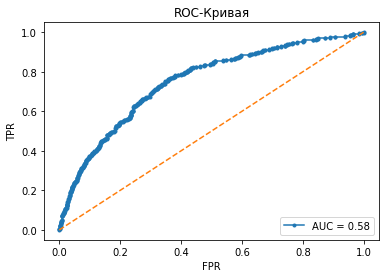



-------------------------------------------------------
Исследование модели Логистической регрессии на данных без RowNumber, CustomerID, Surname (без учета дисбаланса классов):

Значение accuracy со 100% предсказанием значения  0  =  0.7986798679867987
Значение меры accuracy =  0.812981298129813
Значение меры recall =  0.1994535519125683
Значение меры precision =  0.6083333333333333
Значение меры f1 =  0.3004115226337448
Значение меры auc roc =  0.5835422029535292
Значение меры confusion matrix: 
[[1405   47]
 [ 293   73]]


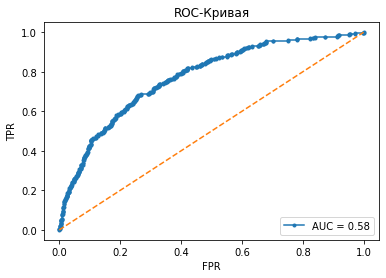

In [13]:
#функция создания модели логистической регрессии
def find_best_LogicalRegression(features_train, target_train, features_valid, target_valid, cls_weight):
    model, predicted_values = make_LogisticRegression_model(features_train,target_train,features_valid, target_valid, False, cls_weight)
    print_basic_metrics(target_valid, predicted_values, model, features_valid)
    return model, predicted_values        

#Выведем полученные метрики для модели логистической регрессии
print('-------------------------------------------------------')
print('Исследование модели Логистической регрессии на полных данных (без учета дисбаланса классов):')  
print()
find_accuracy_zero_model(churn_targ_valid,0)    
LogReg_HO, predict_LogReg_HO = find_best_LogicalRegression(churn_feat_train, churn_targ_train, churn_feat_valid, churn_targ_valid, None)
print()
print()

print('-------------------------------------------------------')
print('Исследование модели Логистической регрессии на данных без RowNumber, CustomerID, Surname (без учета дисбаланса классов):')    
print()
find_accuracy_zero_model(churn_targ_valid,0)    
LogReg_RnCi_HO, predict_LogReg_RnCi_HO = find_best_LogicalRegression(churn_RnCi_feat_train, churn_RnCi_targ_train, churn_RnCi_feat_valid, churn_RnCi_targ_valid, None)
print()
print()
    



Как можно видеть, модель логистической регрессии без учета дисбаланса дает достаточно низкое значение меры f1 при высоком значении accuracy: что неудивительно, так как 80% значений Exited в исходном датасете - нули. У модели логистической регрессии в данном случае весьма низкие показатели как полноты, так и точности, то есть модель совершила довольно много ошибок. Значене меры auc_roc немного выше 0.5 (0.581 и 0.583), что говорит, что модель все-таки немного лучше случайной. 
Практически все метрики у модели на полных немного данных выше, чем у модели без RowNumber, CustomerID, Surname.

<b>Вывод</b><br>
Как можно видеть, на моделях с учетом дисбаланса классов не удалось достичь высоких показателей метрик, особенно низким было значение метрики recall - то есть модели довольно часто принимали единичный класс за нулевой, потому и значение метрики f1 не было слишком высоким. Скорее всего, это также может являться следствием дисбаланса классов. Однако можно сказать, что значение меры auc_roc для всех моделей было выше 0.5, что говорит о том, что полученные модели все-таки лучше случайной. 
<br>
Наиболее высокие показатели метрики f1 удалось достичь у модели "дерево решений", однако они все еще недостаточно высоки. Самые низкие показатели - у модели логистической регрессии<br>
Значения мертрик для обеих моделей (на полных данных и без RowNumber, CustomerID, Surname) были достаточно близкими. В одних случаях они были выше у модели на полных данных, в других - у модели без RowNumber, CustomerID, Surname. Пока что особо значимой рзницы между моделями не видно.
Уберем дисбаланс классов и построим модели на обновленных данных <br>

## Борьба с дисбалансом

<h3>Борьба с дисбалансом путем взвешивания классов</h3>

<h4>Модель"Дерево решений"</h4>

-------------------------------------------------------
Исследование модели "Дерево решений" на полных данных (class_weith = "balanced"):

Значение меры accuracy =  0.812981298129813
Значение меры recall =  0.6038251366120219
Значение меры precision =  0.53125
Значение меры f1 =  0.5652173913043479
Значение меры auc roc =  0.7347638079754325
Значение меры confusion matrix: 
[[1257  195]
 [ 145  221]]


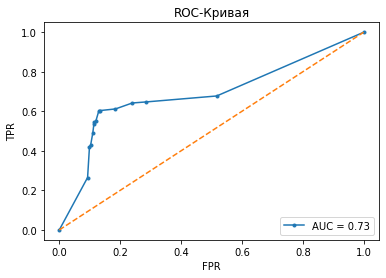



-------------------------------------------------------
Исследование модели "Дерево решений" на данных без RowNumber, CustomerID, Surname (class_weith = "balanced"):

Значение меры accuracy =  0.757975797579758
Значение меры recall =  0.7513661202185792
Значение меры precision =  0.4407051282051282
Значение меры f1 =  0.5555555555555556
Значение меры auc roc =  0.755503996748408
Значение меры confusion matrix: 
[[1103  349]
 [  91  275]]


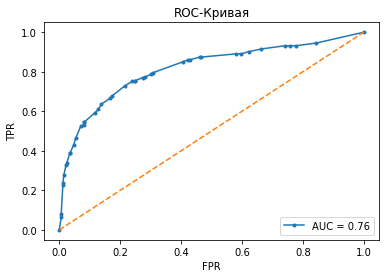

In [14]:
#Построим модели "Дерево решений" со взвешенными классами
print('-------------------------------------------------------')
print('Исследование модели "Дерево решений" на полных данных (class_weith = "balanced"):')  
print()
DecTreeChurn_HO_bal, predict_DecTree_HO = find_best_DecisionTree(churn_feat_train, churn_targ_train, churn_feat_valid, churn_targ_valid, 'balanced')
print()
print()

print('-------------------------------------------------------')
print('Исследование модели "Дерево решений" на данных без RowNumber, CustomerID, Surname (class_weith = "balanced"):')    
print()
DecTreeChurn_RnCi_HO, predict_RnCi_HO = find_best_DecisionTree(churn_RnCi_feat_train, churn_RnCi_targ_train, churn_RnCi_feat_valid, churn_RnCi_targ_valid, 'balanced')
print()
print()

Рассмотрим, как изменились метрики после взвешивания классов: <br>
<b>Модель на полных данных:</b>
<table>
    <tr><td>Метрика</td><td> без взвешивания классов</td><td> с учетом взвешивания классов</td></tr>
    <tr><td>accuracy</td><td> 0.8514851485148515</td><td> 0.812981298129813</td></tr>
    <tr><td>recall</td><td> 0.4918032786885246</td><td>  0.6038251366120219</td></tr>
    <tr><td>precision</td><td> 0.6818181818181818</td><td> 0.53125</td></tr>
    <tr><td>f1</td><td> 0.5714285714285714</td><td> 0.5652173913043479</td></tr>
    <tr><td>auc roc</td><td> 0.7169760195095516</td><td> 0.7347638079754325</td></tr>
</table>
Можно видеть, что значение f1 после взвешивания классов немного уменьшилось, зато значение recall заметно выросло, однако значение precision симметрично уменьшилось: то есть модель стала более полной: правильно прогнозируется больше "единичных" классов, - но менее точной: увеличилось количество неверно предсказанных "единичных" классов". Это также и отразилось на метрике accuracy: модель стала больше ошибаться в целом. Но при этом значение метрики auc roc выросло: то есть соотношение True Positive Answers к True Negative Answers увеличилось 

<b>Модель на данных без RowNumber, CustomerID, Surname:</b>
<table>
    <tr><td>Метрика</td><td> без взвешивания классов</td><td> с учетом взвешивания классов</td></tr>
    <tr><td>accuracy</td><td> 0.841034103410341</td><td> 0.757975797579758 </td></tr>
    <tr><td>recall</td><td> 0.4972677595628415 </td><td> 0.7513661202185792 </td></tr>
    <tr><td>precision</td><td> 0.6341463414634146 </td><td> 0.4407051282051282 </td></tr>
    <tr><td>f1</td><td> 0.557427258805513 </td><td> 0.5555555555555556 </td></tr>
    <tr><td>auc roc</td><td> 0.7124768549880323 </td><td> 0.755503996748408 </td></tr>
</table>
Для модели без данных  RowNumber, CustomerId наблюдается та же тенденция, что и для модели для полных данных. И полученные значения метрик очень близки к значениям модели на полных данных: они лишь незначительно выше. То есть для на модели "дерево решений" особо большой разницы в моделях на полных данных и данных без RowNumber, CustomerID, Surname не видно. <br>
Полученные значения метрик f1 для обеих моделей недостаточно высоки. Рассмотрим также другие модели.

<h4>Модель "Лес Решений"</h4>

-------------------------------------------------------
Исследование модели "Лес решений" на взвешенных полных данных:

Наилучшее значение n_estimators =  31
Наилучшее значение max_depth =  43
Значение меры accuracy =  0.8454345434543454
Значение меры recall =  0.5191256830601093
Значение меры precision =  0.6440677966101694
Значение меры f1 =  0.5748865355521936
Значение меры auc roc =  0.7234058167366662
Значение меры confusion matrix: 
[[1347  105]
 [ 176  190]]


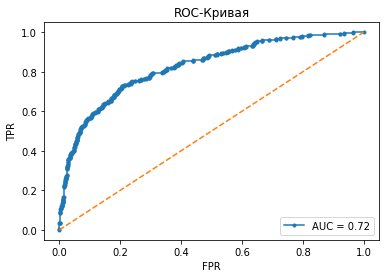



-------------------------------------------------------
Исследование модели "Лес решений" на взвешенных данных без RowNumber, CustomerID, Surname:

Наилучшее значение n_estimators =  23
Наилучшее значение max_depth =  8
Значение меры accuracy =  0.8278327832783279
Значение меры recall =  0.6557377049180327
Значение меры precision =  0.5620608899297423
Значение меры f1 =  0.6052963430012609
Значение меры auc roc =  0.7634749130650769
Значение меры confusion matrix: 
[[1265  187]
 [ 126  240]]


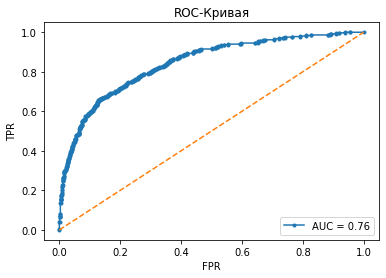

In [15]:
print('-------------------------------------------------------')
print('Исследование модели "Лес решений" на взвешенных полных данных:')  
print()
ForestChurn_HO_bal, predict_Forest_HO_bal = find_best_Forest(churn_feat_train, churn_targ_train, churn_feat_valid, churn_targ_valid, 'balanced')
print()
print()
print('-------------------------------------------------------')
print('Исследование модели "Лес решений" на взвешенных данных без RowNumber, CustomerID, Surname:')  
print() 
ForestChurn_RnCi_HO_bal, predict_RnCi_Forest_HO_bal = find_best_Forest(churn_RnCi_feat_train, churn_RnCi_targ_train, churn_RnCi_feat_valid, churn_RnCi_targ_valid, 'balanced')
print()
print()    

Рассмотрим, как изменились метрики после взвешивания классов: <br>
<b>Модель на полных данных:</b>
<table>
    <tr><td>Метрика</td><td> без взвешивания классов</td><td> с учетом взвешивания классов</td></tr>
    <tr><td>accuracy</td><td>0.8476347634763476 </td><td> 0.8454345434543454</td></tr>
    <tr><td>recall</td><td> 0.3087431693989071 </td><td> 0.5191256830601093</td></tr>
    <tr><td>precision</td><td>0.8248175182481752</td><td>0.6440677966101694</td></tr>
    <tr><td>f1</td><td>0.44930417495029823 </td><td> 0.5748865355521936</td></tr>
    <tr><td>auc roc</td><td> 0.6461071218895362</td><td>0.7234058167366662</td></tr>
</table>
Взвешивание классов значительно улучшило модель "Лес решений" на полных данных: метрика accuarcy изменилась незначительно, зато метрика f1 и auc roc (соотношение TPR к FPR) выросли очень заметно, то есть модель стала более адекватно находить True Positive значения, стала меньше ошибаться, можно также видеть значительное увеличение метрики recall, что также говорит о том, что модель находит больше True Positive значений. Однако значение метрики precision уменьшилось: стало поялвяться больше False Positive значени. 

<b>Модель на данных без RowNumber, CustomerID, Surname:</b>
<table>
<tr>
		<td>метрика</td>
		<td>без учета дисбаланса</td>
		<td>взвешенные данные</td>
	</tr>
	<tr>
		<td>accuracy</td>
		<td>0.8624862486248625</td>
		<td>0.8278327832783279</td>
	</tr>
	<tr>
		<td>recall</td>
		<td>0.43989071038251365</td>
		<td>0.6557377049180327</td>
	</tr>
	<tr>
		<td>precision</td>
		<td>0.7815533980582524</td>
		<td>0.5620608899297423</td>
	</tr>
	<tr>
		<td>f1</td>
		<td>0.5629370629370629</td>
		<td>0.6052963430012609</td>
	</tr>
	<tr>
		<td>auc roc</td>
		<td>0.7044494874226618</td>
		<td>0.7634749130650769</td>
	</tr>
	</table>
Общая картина на модели данных без RowNumber, CustomerID, Surname схожа с картиной на полных данных, однако значения практически всех метрик (за исключением precision и accuracy) у модели без RowNumber, CustomerID, Surname выше: то есть у этой модели количество False Positive значений больше.  

<h4>Модель "Логистическая регрессия"</h4>

-------------------------------------------------------
Исследование модели Логистической регрессии на взвешенных полных данных:

Значение меры accuracy =  0.7293729372937293
Значение меры recall =  0.587431693989071
Значение меры precision =  0.38669064748201437
Значение меры f1 =  0.4663774403470716
Значение меры auc roc =  0.6762916045702931
Значение меры confusion matrix: 
[[1111  341]
 [ 151  215]]


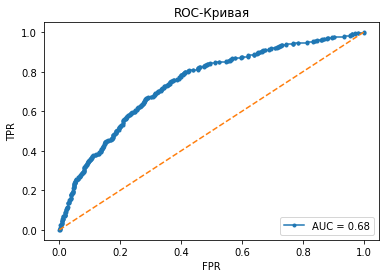



-------------------------------------------------------
Исследование модели Логистической регрессии на взвешенных данных без RowNumber, CustomerID, Surname:

Значение меры accuracy =  0.7183718371837183
Значение меры recall =  0.6857923497267759
Значение меры precision =  0.3873456790123457
Значение меры f1 =  0.49506903353057197
Значение меры auc roc =  0.7061881858826717
Значение меры confusion matrix: 
[[1055  397]
 [ 115  251]]


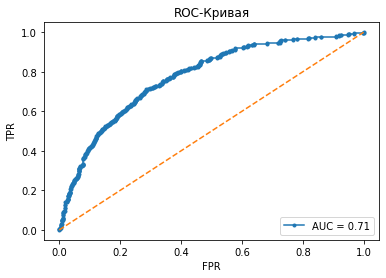

In [16]:
print('-------------------------------------------------------')
print('Исследование модели Логистической регрессии на взвешенных полных данных:')  
print()  
LogReg_HO_bal, predict_LogReg_HO_bal = find_best_LogicalRegression(churn_feat_train, churn_targ_train, churn_feat_valid, churn_targ_valid, 'balanced')
print()
print()

print('-------------------------------------------------------')
print('Исследование модели Логистической регрессии на взвешенных данных без RowNumber, CustomerID, Surname:')    
print()
LogReg_RnCi_HO_bal, predict_LogReg_RnCi_HO_bal = find_best_LogicalRegression(churn_RnCi_feat_train, churn_RnCi_targ_train, churn_RnCi_feat_valid, churn_RnCi_targ_valid, 'balanced')
print()
print()

Рассмотрим, как изменились метрики после взвешивания классов: <br>
<b>Модель на полных данных:</b>
<table>
    <tr><td>Метрика</td><td> без взвешивания классов</td><td> с учетом взвешивания классов</td></tr>
    <tr><td>accuracy</td><td>0.8074807480748075</td><td> 0.7293729372937293</td></tr>
    <tr><td>recall</td><td> 0.20218579234972678  </td><td> 0.587431693989071 </td></tr>
    <tr><td>precision</td><td>0.5606060606060606</td><td>0.38669064748201437 </td></tr>
    <tr><td>f1</td><td> 0.2971887550200803  </td><td> 0.4663774403470716</td></tr>
    <tr><td>auc roc</td><td> 0.5811204443842297 </td><td>0.6762916045702931 </td></tr>
</table>
Можоно видеть, что значения практически всех метрик (за исключением precision и accuracy) значительно выросили, однакко они все еще остаются слишком низкими, так что данную модель нельзя считать лучшей. Взвешивание классов привело к увеличению полноты, но снижению точности: модель стала больше попадать в positive класс, но в то же время увелчилось количество false positive предсказаний. В любом случае, модель хоть и лучше случайной (auc roc > 0.5), но все равно недостатоно соответствует требованиям.

<b>Модель на данных без RowNumber, CustomerID, Surname:</b>
<table>
    <tr>
		<td>метрика</td>
		<td>без учета дисбаланса</td>
		<td>взвешенные данные</td>
	</tr>
	<tr>
		<td>accuracy</td>
		<td>0.812981298129813</td>
		<td>0.7183718371837183</td>
	</tr>
	<tr>
		<td>recall</td>
		<td>0.1994535519125683</td>
		<td>0.6857923497267759</td>
	</tr>
	<tr>
		<td>precision</td>
		<td>0.6083333333333333</td>
		<td>0.3873456790123457</td>
	</tr>
	<tr>
		<td>f1</td>
		<td>0.3004115226337448</td>
		<td>0.49506903353057197</td>
	</tr>
	<tr>
		<td>auc roc</td>
		<td>0.5835422029535292</td>
		<td>0.7061881858826717</td>
	</tr>
</table>
Общая картина для модели на данных без RowNumber, CustomerID, Surname схожа с картиной на полных данных, но значение всех метрик немного выше, хотя все еще остается недостаточно высоким. 

Модели на взвешенных данных дали лучшие результаты, чем модели на неизмененных данных. однако эти результаты остаются достаточно низкими. Рассмотрим другие способы борьбы с дисбалансом

<h3>Борьба с дисбалансом путем увеличения выборки</h3>

Для начала напишем функцию увеличения выборки

In [17]:
def upsample(features,target,repeat):#функция для увеличения выборки
    #выделим строки с нулевым и единичным значением target
    features_zero = features[target == 0]
    features_one = features[target == 1]
    target_zero = target[target == 0]
    target_one = target[target == 1]
    #увеличиваем количество
    features_upsampled = pd.concat([features_zero] + [features_one] * repeat)
    target_upsampled = pd.concat([target_zero] + [target_one] * repeat)
    #перемешиваем
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state = RANDOM_STATE)
    return features_upsampled, target_upsampled

#зададим значение repeat, чтобы уравнять значения нулей и единиц. Ранее мы видели, что нулевых
#значений в Exited около 80%, тогда как единиц - 20%. Таким образом нужно увеличить выборку по
#единичным значениям в 4 раза (80/20)
repeat = 4
churn_feat_train_ups, churn_targ_train_ups = upsample(churn_feat_train, churn_targ_train, repeat)
churn_RnCi_feat_train_ups, churn_RnCi_targ_train_ups = upsample(churn_RnCi_feat_train, churn_RnCi_targ_train,repeat)

print('Доля значений каждого класса после преобразования')
print(churn_targ_train_ups.value_counts(normalize = True))

Доля значений каждого класса после преобразования
1    0.508001
0    0.491999
Name: Exited, dtype: float64


<h4>Модель "Дерево решений" на upsampled выборке</h4>

-------------------------------------------------------
Исследование модели Дерево решений на полных данных после увеличения выборки:

Значение меры accuracy =  0.8151815181518152
Значение меры recall =  0.6010928961748634
Значение меры precision =  0.5365853658536586
Значение меры f1 =  0.5670103092783505
Значение меры auc roc =  0.7351194508422526
Значение меры confusion matrix: 
[[1262  190]
 [ 146  220]]


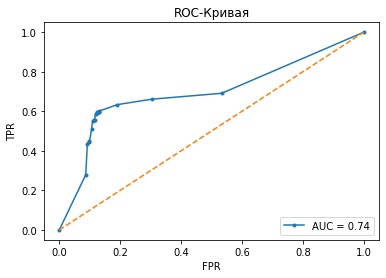



-------------------------------------------------------
Исследование модели Дерево решений на данных без RowNumber, CustomerID, Surname после увеличения выборки:

Значение меры accuracy =  0.757975797579758
Значение меры recall =  0.7513661202185792
Значение меры precision =  0.4407051282051282
Значение меры f1 =  0.5555555555555556
Значение меры auc roc =  0.755503996748408
Значение меры confusion matrix: 
[[1103  349]
 [  91  275]]


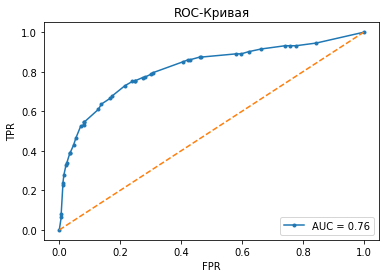

In [18]:
print('-------------------------------------------------------')
print('Исследование модели Дерево решений на полных данных после увеличения выборки:')  
print()
 
DecTreeChurn_HO_ups, predict_DecTree_HO_ups = find_best_DecisionTree(churn_feat_train_ups, churn_targ_train_ups, churn_feat_valid, churn_targ_valid, None)
print()
print()

print('-------------------------------------------------------')
print('Исследование модели Дерево решений на данных без RowNumber, CustomerID, Surname после увеличения выборки:')    
print()
   
DecTreeChurn_RnCi_HO_ups, predict_RnCi_HO_ups = find_best_DecisionTree(churn_RnCi_feat_train_ups, churn_RnCi_targ_train_ups, churn_RnCi_feat_valid, churn_RnCi_targ_valid, None)
print()
print()

Рассмотрим, как изменились метрики : <br>
<b>Модель на полных данных:</b>
<table>
    <tr><td>Метрика</td><td>без учета дисбаланса</td><td>взвешивание классов</td><td>увеличение выборки</td></tr>
    <tr><td>accuracy</td><td> 0.8514851485148515</td><td > 0.812981298129813</td><td>0.8151815181518152</td></tr>
    <tr><td>recall</td><td> 0.4918032786885246</td><td>  0.6038251366120219</td><td> 0.6010928961748634</td></tr>
    <tr><td>precision</td><td> 0.6818181818181818</td><td> 0.53125</td><td>0.5365853658536586</td></tr>
    <tr><td>f1</td><td> 0.5714285714285714</td><td> 0.5652173913043479</td><td  bgcolor = #ffcc00>0.5670103092783505</td></tr>
    <tr><td>auc roc</td><td> 0.7169760195095516</td><td> 0.7347638079754325</td><td > 0.7351194508422526</td></tr>
</table>
Значения метрик после увеличения выборки немного ниже, чем после взвешивания классов. Для модели "дерево решений" среди всех проверенных вариантов наилучший пока -  дерево решений после увеличения выборки

<b>Модель на данных без RowNumber, CustomerID, Surname:</b>
<table>
   <tr>
		<td>метрика</td>
		<td>без учета дисбаланса</td>
		<td>взвешенные данные</td>
		<td>увеличение выборки</td>
	</tr>
	<tr>
		<td>accuracy</td>
		<td>0.841034103410341</td>
		<td>0.757975797579758</td>
		<td>0.757975797579758</td>
	</tr>
	<tr>
		<td>recall</td>
		<td>0.4972677595628415</td>
		<td>0.7513661202185792</td>
		<td>0.7513661202185792</td>
	</tr>
	<tr>
		<td>precision</td>
		<td>0.6341463414634146</td>
		<td>0.4407051282051282</td>
		<td>0.4407051282051282</td>
	</tr>
	<tr>
		<td>f1</td>
		<td  bgcolor = #ffcc00>0.557427258805513</td>
		<td>0.5555555555555556</td>
		<td>0.5555555555555556</td>
	</tr>
	<tr>
		<td>auc roc</td>
		<td>0.7124768549880323</td>
		<td>0.755503996748408</td>
		<td>0.755503996748408</td>
	</tr>
</table>

Для модели данных без  RowNumber, CustomerId картина не очень схожа с моделью на полных данных: для моделей на взвешенных данных и на увеличенной выборке значения практически одинаковы. Наиболее высокое значение f1 достигается на модели без учета дисбаланса

<h4>Модель "лес решений" на upsampled данных</h4>

-------------------------------------------------------
Исследование модели "Лес решений" на upsampled данных:

Наилучшее значение n_estimators =  103
Наилучшее значение max_depth =  49
Значение меры accuracy =  0.8443344334433444
Значение меры recall =  0.5655737704918032
Значение меры precision =  0.6253776435045317
Значение меры f1 =  0.593974175035868
Значение меры auc roc =  0.7400871607279953
Значение меры confusion matrix: 
[[1328  124]
 [ 159  207]]


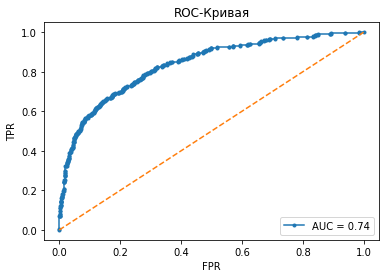



-------------------------------------------------------
Исследование модели "Лес решений" на upsampled данных без RowNumber, CustomerID, Surname:

Наилучшее значение n_estimators =  22
Наилучшее значение max_depth =  8
Значение меры accuracy =  0.8168316831683168
Значение меры recall =  0.7021857923497268
Значение меры precision =  0.5343035343035343
Значение меры f1 =  0.6068476977567886
Значение меры auc roc =  0.7739579099489681
Значение меры confusion matrix: 
[[1228  224]
 [ 109  257]]


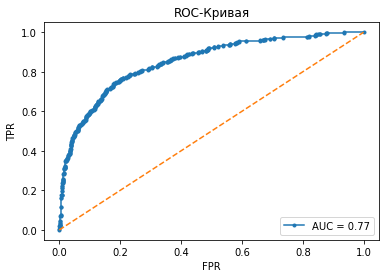

In [19]:
print('-------------------------------------------------------')
print('Исследование модели "Лес решений" на upsampled данных:')  
print()
ForestChurn_HO_ups, predict_Forest_HO_ups = find_best_Forest(churn_feat_train_ups, churn_targ_train_ups, churn_feat_valid, churn_targ_valid, None)
print()
print()
print('-------------------------------------------------------')
print('Исследование модели "Лес решений" на upsampled данных без RowNumber, CustomerID, Surname:')  
print() 
ForestChurn_RnCi_HO_ups, predict_RnCi_Forest_HO_ups = find_best_Forest(churn_RnCi_feat_train_ups, churn_RnCi_targ_train_ups, churn_RnCi_feat_valid, churn_RnCi_targ_valid, None)
print()
print() 

Рассмотрим, как изменились метрики: <br>
<b>Модель на полных данных:</b>
<table>
    <tr><td>Метрика</td><td> без учета дисбаланса</td><td> взвешивание классов</td><td>увеличение выборки</td></tr>
    <tr><td>accuracy</td><td>0.8476347634763476 </td><td> 0.8454345434543454</td><td >0.8443344334433444</td></tr>
    <tr><td>recall</td><td> 0.3087431693989071 </td><td> 0.5191256830601093</td><td >0.5655737704918032</td></tr>
    <tr><td>precision</td><td>0.8248175182481752</td><td>0.6440677966101694</td><td> 0.6253776435045317</td></tr>
    <tr><td>f1</td><td>0.44930417495029823 </td><td> 0.5748865355521936</td><td bgcolor = #ffcc00> 0.593974175035868</td></tr>
    <tr><td>auc roc</td><td> 0.6461071218895362</td><td>0.7234058167366662</td><td>0.7400871607279953</td></tr>
</table>

На модели "Лес решений" на полных данных после увеличения выборки значние метрики f1 выросло до 0.593, да и по всем остальным метрикам, за исключением precision и accuarcy наблюдается заметный рост. Очевидно, модель стала лучше определять единичный клас, но при этом количество False Positive результатов увеличилось. 

<b>Модель на данных без RowNumber, CustomerID, Surname:</b>
<table>
    <tr>
		<td>метрика</td>
		<td>без учета дисбаланса</td>
		<td>взвешенные данные</td>
		<td>увеличение выборки</td>
	</tr>
	<tr>
		<td>accuracy</td>
		<td>0.8624862486248625</td>
		<td>0.8278327832783279</td>
		<td>0.8168316831683168</td>
	</tr>
	<tr>
		<td>recall</td>
		<td>0.43989071038251365</td>
		<td>0.6557377049180327</td>
		<td>0.7021857923497268</td>
	</tr>
	<tr>
		<td>precision</td>
		<td>0.7815533980582524</td>
		<td>0.5620608899297423</td>
		<td>0.5343035343035343</td>
	</tr>
	<tr>
		<td>f1</td>
		<td>0.5629370629370629</td>
		<td>0.6052963430012609</td>
		<td bgcolor = #ffcc00>0.6068476977567886</td>
	</tr>
	<tr>
		<td>auc roc</td>
		<td>0.7044494874226618</td>
		<td>0.7634749130650769</td>
		<td>0.7739579099489681</td>
	</tr>
</table>
Общая картина на модели "Лес решений" на увеличенной выборке для данных без RowNumber, CustomerID, Surname очень схолжа с данными модели "Лес решений" на увеличенной выборке для полных данных, однако большинство параметров (в том числе f1, aucr roc, recall) заметно выше значений метрики на полных данных

<h4>Построение модели логистической регрессии на upsampled данных</h4>

-------------------------------------------------------
Исследование модели Логистической регрессии на взвешенных полных данных:

Значение меры accuracy =  0.7288228822882288
Значение меры recall =  0.5765027322404371
Значение меры precision =  0.3843351548269581
Значение меры f1 =  0.4612021857923498
Значение меры auc roc =  0.6718601815472158
Значение меры confusion matrix: 
[[1114  338]
 [ 155  211]]


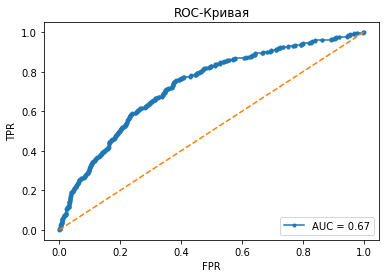



-------------------------------------------------------
Исследование модели Логистической регрессии на взвешенных данных без RowNumber, CustomerID, Surname:

Значение меры accuracy =  0.7123212321232123
Значение меры recall =  0.7021857923497268
Значение меры precision =  0.3830104321907601
Значение меры f1 =  0.4956605593056895
Значение меры auc roc =  0.708530912703789
Значение меры confusion matrix: 
[[1038  414]
 [ 109  257]]


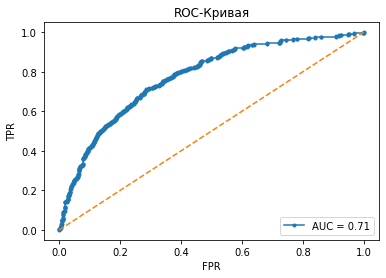

In [20]:
print('-------------------------------------------------------')
print('Исследование модели Логистической регрессии на взвешенных полных данных:')  
print()  
LogReg_HO_ups, predict_LogReg_HO_ups = find_best_LogicalRegression(churn_feat_train_ups, churn_targ_train_ups, churn_feat_valid, churn_targ_valid, None)
print()
print()

print('-------------------------------------------------------')
print('Исследование модели Логистической регрессии на взвешенных данных без RowNumber, CustomerID, Surname:')    
print()
LogReg_RnCi_HO_ups, predict_LogReg_RnCi_HO_ups = find_best_LogicalRegression(churn_RnCi_feat_train_ups, churn_RnCi_targ_train_ups, churn_RnCi_feat_valid, churn_RnCi_targ_valid, None)
print()
print()

Рассмотрим, как изменились метрики: <br>
<b>Модель на полных данных:</b>
<table>
    <tr><td>Метрика</td><td> без учета дисбаланса</td><td> взвешивание классов</td><td>увеличение выборки</td></tr>
    <tr><td>accuracy</td><td>0.8074807480748075</td><td> 0.7293729372937293</td><td> 0.7288228822882288</td></tr>
    <tr><td>recall</td><td> 0.20218579234972678  </td><td> 0.587431693989071 </td><td>0.5765027322404371</td></tr>
    <tr><td>precision</td><td>0.5606060606060606</td><td>0.38669064748201437 </td><td> 0.3843351548269581</td></tr>
    <tr><td>f1</td><td> 0.2971887550200803  </td><td bgcolor = #ffcc00> 0.4663774403470716</td><td>0.4612021857923498</td></tr>
    <tr><td>auc roc</td><td> 0.5811204443842297 </td><td>0.6762916045702931 </td><td>0.6718601815472158</td></tr>
</table>
Метрики для модели логистической регрессии не улучшились по сравнению с метриками после борьбы с дисбалансом методом взвешивания классов. Данная модель явно не является лучшей среди рассмотренных

<b>Модель на данных без RowNumber, CustomerID, Surname:</b>
<table>
    <tr>
		<td>метрика</td>
		<td>без учета дисбаланса</td>
		<td>взвешенные данные</td>
		<td>увеличение выборки</td>
	</tr>
	<tr>
		<td>accuracy</td>
		<td>0.812981298129813</td>
		<td>0.7183718371837183</td>
		<td>0.7123212321232123</td>
	</tr>
	<tr>
		<td>recall</td>
		<td>0.1994535519125683</td>
		<td>0.6857923497267759</td>
		<td>0.7021857923497268</td>
	</tr>
	<tr>
		<td>precision</td>
		<td>0.6083333333333333</td>
		<td>0.3873456790123457</td>
		<td>0.3830104321907601</td>
	</tr>
	<tr>
		<td>f1</td>
		<td>0.3004115226337448</td>
		<td>0.49506903353057197</td>
		<td  bgcolor = #ffcc00>0.4956605593056895</td>
	</tr>
	<tr>
		<td>auc roc</td>
		<td>0.5835422029535292</td>
		<td>0.7061881858826717</td>
		<td>0.708530912703789</td>
	</tr>
</table>
Общая картина для модели логистической регрессии на данных без RowNumber, CustomerID, Surname схожа с картиной модели на полных данных, одаком метрики для модели на данных без RowNumber, CustomerID, Surname несколько выше, чем на модели на полных данных, но данная модель не является лучшей из рассмотренных

<h3>Борьба с дисбалансом путем уменьшения выборки</h3>

In [21]:
#функция для уменьшения выборки
def downsample(features, target, fraction):
    #разделяем выборку на классы
    features_zero = features[target == 0]
    features_one = features[target == 1]
    target_zero = target[target == 0]
    target_one = target[target == 1]
    #уменьшаем нулевой класс и объединяем с единичным
    features_downsampled = pd.concat([features_zero.sample(frac = fraction, random_state = RANDOM_STATE)] + [features_one])
    target_downsampled = pd.concat([target_zero.sample(frac = fraction, random_state = RANDOM_STATE)] + [target_one])
    #перемешиваем значения
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled,random_state = RANDOM_STATE)
    return features_downsampled, target_downsampled

fraction = 0.25
churn_feat_train_dns, churn_targ_train_dns = downsample(churn_feat_train, churn_targ_train, fraction)
churn_RnCi_feat_train_dns, churn_RnCi_targ_train_dns = downsample(churn_RnCi_feat_train, churn_RnCi_targ_train,fraction)
print('Доля значений каждого класса после преобразования')
print(churn_targ_train_dns.value_counts(normalize = True))


Доля значений каждого класса после преобразования
1    0.507944
0    0.492056
Name: Exited, dtype: float64


Количество значений каждого класса приблизительно одинаково. можно тестировать модели

<h4>Построение модели "Дерево решений" на downsampled данных</h4>

-------------------------------------------------------
Исследование модели Дерево решений на полных данных после уменьшения выборки:

Значение меры accuracy =  0.8047304730473047
Значение меры recall =  0.6038251366120219
Значение меры precision =  0.5127610208816705
Значение меры f1 =  0.5545796737766625
Значение меры auc roc =  0.7295985187192341
Значение меры confusion matrix: 
[[1242  210]
 [ 145  221]]


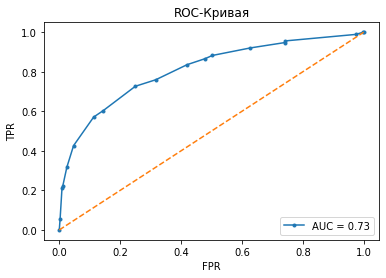



-------------------------------------------------------
Исследование модели Дерево решений на данных без RowNumber, CustomerID, Surname после уменьшения выборки:

Значение меры accuracy =  0.8036303630363036
Значение меры recall =  0.6038251366120219
Значение меры precision =  0.5103926096997691
Значение меры f1 =  0.553191489361702
Значение меры auc roc =  0.7289098134850742
Значение меры confusion matrix: 
[[1240  212]
 [ 145  221]]


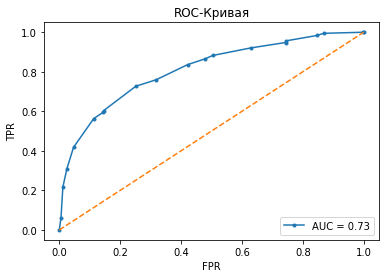

In [22]:
print('-------------------------------------------------------')
print('Исследование модели Дерево решений на полных данных после уменьшения выборки:')  
print()
DecTreeChurn_HO_dns, predict_DecTree_HO_dns = find_best_DecisionTree(churn_feat_train_dns, churn_targ_train_dns, churn_feat_valid, churn_targ_valid, None)
print()
print()
print('-------------------------------------------------------')
print('Исследование модели Дерево решений на данных без RowNumber, CustomerID, Surname после уменьшения выборки:')    
print()
DecTreeChurn_RnCi_HO_dns, predict_RnCi_HO_dns = find_best_DecisionTree(churn_RnCi_feat_train_dns, churn_RnCi_targ_train_dns, churn_RnCi_feat_valid, churn_RnCi_targ_valid, None)
print()
print()

Рассмотрим, как изменились метрики : <br>
<b>Модель на полных данных:</b>
<table>
    <tr><td>Метрика</td><td>без учета дисбаланса</td><td>взвешивание классов</td><td>увеличение выборки</td><td>уменьшение выборки</td></tr>
    <tr><td>accuracy</td><td> 0.8514851485148515</td><td > 0.812981298129813</td><td>0.8151815181518152</td><td>0.8047304730473047</td></tr>
    <tr><td>recall</td><td> 0.4918032786885246</td><td>  0.6038251366120219</td><td > 0.6010928961748634</td><td> 0.6038251366120219</td></tr>
    <tr><td>precision</td><td> 0.6818181818181818</td><td> 0.53125</td><td>0.5365853658536586</td><td>0.5127610208816705</td></tr>
    <tr><td>f1</td><td> 0.5714285714285714</td><td> 0.5652173913043479</td><td  bgcolor = #ffcc00>0.5670103092783505</td><td>0.5545796737766625</td></tr>
    <tr><td>auc roc</td><td> 0.7169760195095516</td><td> 0.7347638079754325</td><td> 0.7351194508422526</td><td> 0.7295985187192341</td></tr>
</table>
Модель "дерево решений" на уменьшенной выборке показала более низкие значения метрик, чем модель на увеличенной выбоорке, хотя и более близкие к ним (исключение составляет только метрика recall, хотя нас интересуют и recall, и precision,  поэтому учитываем только значение агрегированной метрики f1: а оно уменьшлось, как и значение auc roc). В любом случае, показатель метрики f1 недостаточно высок. Поэтому данную метрику нельзя считать лучшей.

<b>Модель на данных без RowNumber, CustomerID, Surname:</b>
<table>
    <tr>
		<td>метрика</td>
		<td>без учета дисбаланса</td>
		<td>взвешенные данные</td>
		<td>увеличение выборки</td>
		<td>уменьшение выборки</td>
	</tr>
	<tr>
		<td>accuracy</td>
		<td>0.841034103410341</td>
		<td>0.757975797579758</td>
		<td>0.757975797579758</td>
		<td>0.8036303630363036</td>
	</tr>
	<tr>
		<td>recall</td>
		<td>0.4972677595628415</td>
		<td>0.7513661202185792</td>
		<td>0.7513661202185792</td>
		<td>0.6038251366120219</td>
	</tr>
	<tr>
		<td>precision</td>
		<td>0.6341463414634146</td>
		<td>0.4407051282051282</td>
		<td>0.4407051282051282</td>
		<td>0.5103926096997691</td>
	</tr>
	<tr>
		<td>f1</td>
		<td  bgcolor = #ffcc00>0.557427258805513</td>
		<td>0.5555555555555556</td>
		<td>0.5555555555555556</td>
		<td>0.553191489361702</td>
	</tr>
	<tr>
		<td>auc roc</td>
		<td>0.7124768549880323</td>
		<td>0.755503996748408</td>
		<td>0.755503996748408</td>
		<td>0.7289098134850742</td>
	</tr>
</table>
В целом картина жля модели без RowNumber, CustomerID, Surname отличается картиной на полных данных: данная мдель имеет самое меньшее значение f1 из всех моделей "Дерево решений". Наиболее высокие значения f1 для модели "Дерево решений" достигаются на данных без учета дисбаланса, но это значение недостаточно велико 


<h4>Построение модели "Лес решений" на downsampled выборке</h4>

-------------------------------------------------------
Исследование модели "Лес решений" на downsampled данных:

Наилучшее значение n_estimators =  122
Наилучшее значение max_depth =  36
Значение меры accuracy =  0.7805280528052805
Значение меры recall =  0.7513661202185792
Значение меры precision =  0.4716981132075472
Значение меры f1 =  0.5795574288724974
Значение меры auc roc =  0.7696224540486835
Значение меры confusion matrix: 
[[1144  308]
 [  91  275]]


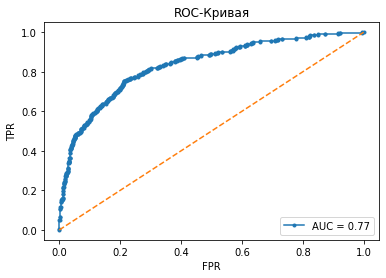



-------------------------------------------------------
Исследование модели "Лес решений" на downsampled данных без RowNumber, CustomerID, Surname:

Наилучшее значение n_estimators =  76
Наилучшее значение max_depth =  15
Значение меры accuracy =  0.7970297029702971
Значение меры recall =  0.7349726775956285
Значение меры precision =  0.49722735674676527
Значение меры f1 =  0.5931642778390298
Значение меры auc roc =  0.7738224269520843
Значение меры confusion matrix: 
[[1180  272]
 [  97  269]]


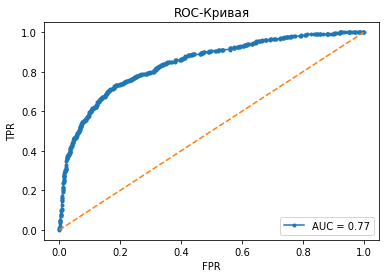

In [23]:
print('-------------------------------------------------------')
print('Исследование модели "Лес решений" на downsampled данных:')  
print()
ForestChurn_HO_dns, predict_Forest_HO_dns = find_best_Forest(churn_feat_train_dns, churn_targ_train_dns, churn_feat_valid, churn_targ_valid, None)
print()
print()
print('-------------------------------------------------------')
print('Исследование модели "Лес решений" на downsampled данных без RowNumber, CustomerID, Surname:')  
print() 
ForestChurn_RnCi_HO_dns, predict_RnCi_Forest_HO_dns = find_best_Forest(churn_RnCi_feat_train_dns, churn_RnCi_targ_train_dns, churn_RnCi_feat_valid, churn_RnCi_targ_valid, None)
print()
print() 




Рассмотрим, как изменились метрики : <br>
<b>Модель на полных данных:</b>
<table>
    <tr><td>Метрика</td><td>без учета дисбаланса</td><td>взвешивание классов</td><td>увеличение выборки</td><td>уменьшение выборки</td></tr>
    <tr><td>accuracy</td><td>0.8476347634763476 </td><td> 0.8454345434543454</td><td >0.8443344334433444</td><td>0.7805280528052805</td></tr>
    <tr><td>recall</td><td> 0.3087431693989071 </td><td> 0.5191256830601093</td><td>0.5655737704918032</td><td> 0.7513661202185792</td></tr>
    <tr><td>precision</td><td>0.8248175182481752</td><td>0.6440677966101694</td><td> 0.6253776435045317</td><td>0.4716981132075472</td></tr>
    <tr><td>f1</td><td>0.44930417495029823 </td><td> 0.5748865355521936</td><td bgcolor = #ffcc00> 0.593974175035868</td><td> 0.5795574288724974</td></tr>
    <tr><td>auc roc</td><td> 0.6461071218895362</td><td>0.7234058167366662</td><td>0.7400871607279953</td><td>0.7696224540486835</td></tr>
</table>

<b>Модель на данных без RowNumber, CustomerID, Surname:</b>
<table>
 <tr>
		<td>метрика</td>
		<td>без учета дисбаланса</td>
		<td>взвешенные данные</td>
		<td>увеличение выборки</td>
		<td>уменьшение выборки</td>
	</tr>
	<tr>
		<td>accuracy</td>
		<td>0.8624862486248625</td>
		<td>0.8278327832783279</td>
		<td>0.8168316831683168</td>
		<td>0.7970297029702971</td>
	</tr>
	<tr>
		<td>recall</td>
		<td>0.43989071038251365</td>
		<td>0.6557377049180327</td>
		<td>0.7021857923497268</td>
		<td>0.7349726775956285</td>
	</tr>
	<tr>
		<td>precision</td>
		<td>0.7815533980582524</td>
		<td>0.5620608899297423</td>
		<td>0.5343035343035343</td>
		<td>0.49722735674676527</td>
	</tr>
	<tr>
		<td>f1</td>
		<td>0.5629370629370629</td>
		<td>0.6052963430012609</td>
		<td  bgcolor = #ffcc00>0.6068476977567886</td>
		<td>0.5931642778390298</td>
	</tr>
	<tr>
		<td>auc roc</td>
		<td>0.7044494874226618</td>
		<td>0.7634749130650769</td>
		<td>0.7739579099489681</td>
		<td>0.7738224269520843</td>
	</tr>
</table>
У обеих моделей значения метрик f1 ниже, чем у моделей на upsampled данных, причем значително, однако увелчились значения метрик recall и auc roc: false negative значений стало меньше, то есть модель стала более полной, но менее точной, а нам необходима максимизация обоих показателей. Поэтому считаем, что модель на upsampled данных больше подходит для решения поствленной задачи<br>
Показатели на модели без RowNumber, CustomerID, Surname несколько выше, чем для модели на полных данных.

<h4>Построение модели логистической регрессии на downsampled данных</h4>

-------------------------------------------------------
Исследование модели Логистической регрессии на взвешенных полных данных:

Значение меры accuracy =  0.7029702970297029
Значение меры recall =  0.6857923497267759
Значение меры precision =  0.371301775147929
Значение меры f1 =  0.48176583493282144
Значение меры auc roc =  0.6965463126044347
Значение меры confusion matrix: 
[[1027  425]
 [ 115  251]]


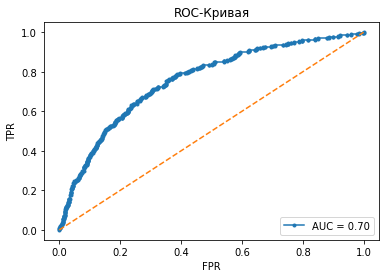



-------------------------------------------------------
Исследование модели Логистической регрессии на взвешенных данных без RowNumber, CustomerID, Surname:

Значение меры accuracy =  0.7194719471947195
Значение меры recall =  0.6967213114754098
Значение меры precision =  0.38990825688073394
Значение меры f1 =  0.5
Значение меры auc roc =  0.7109639615228289
Значение меры confusion matrix: 
[[1053  399]
 [ 111  255]]


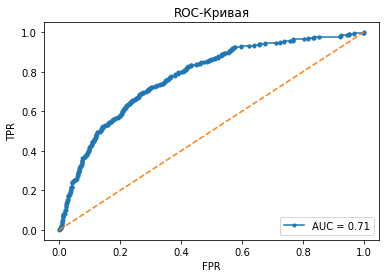

In [24]:
print('-------------------------------------------------------')
print('Исследование модели Логистической регрессии на взвешенных полных данных:')  
print()  
LogReg_HO_dns, predict_LogReg_HO_dns = find_best_LogicalRegression(churn_feat_train_dns, churn_targ_train_dns, churn_feat_valid, churn_targ_valid, None)
print()
print()

print('-------------------------------------------------------')
print('Исследование модели Логистической регрессии на взвешенных данных без RowNumber, CustomerID, Surname:')    
print()
LogReg_RnCi_HO_dns, predict_LogReg_RnCi_HO_dns = find_best_LogicalRegression(churn_RnCi_feat_train_dns, churn_RnCi_targ_train_dns, churn_RnCi_feat_valid, churn_RnCi_targ_valid, None)
print()
print()

Рассмотрим, как изменились метрики: <br>
<b>Модель на полных данных:</b>
<table>
    <tr><td>Метрика</td><td> без учета дисбаланса</td><td> взвешивание классов</td><td>увеличение выборки</td><td>уменьшение выборки</td></tr>
    <tr><td>accuracy</td><td>0.8074807480748075</td><td> 0.7293729372937293</td><td> 0.7288228822882288</td><td>0.7029702970297029</td></tr>
    <tr><td>recall</td><td> 0.20218579234972678  </td><td> 0.587431693989071 </td><td>0.5765027322404371</td><td>0.6857923497267759</td></tr>
    <tr><td>precision</td><td>0.5606060606060606</td><td>0.38669064748201437 </td><td> 0.3843351548269581</td><td> 0.371301775147929</td></tr>
    <tr><td>f1</td><td> 0.2971887550200803  </td><td> 0.4663774403470716</td><td>0.4612021857923498</td><td  bgcolor = #ffcc00>0.48176583493282144</td></tr>
    <tr><td>auc roc</td><td> 0.5811204443842297 </td><td>0.6762916045702931 </td><td>0.6718601815472158</td><td>0.6965463126044347</td></tr>
</table>


<b>Модель на данных без RowNumber, CustomerID, Surname:</b>
<table>
    <tr>
		<td>метрика</td>
		<td>без учета дисбаланса</td>
		<td>взвешенные данные</td>
		<td>увеличение выборки</td>
		<td>уменьшение выборки</td>
	</tr>
	<tr>
		<td>accuracy</td>
		<td>0.812981298129813</td>
		<td>0.7183718371837183</td>
		<td>0.7123212321232123</td>
		<td>0.7194719471947195</td>
	</tr>
	<tr>
		<td>recall</td>
		<td>0.1994535519125683</td>
		<td>0.6857923497267759</td>
		<td>0.7021857923497268</td>
		<td>0.6967213114754098</td>
	</tr>
	<tr>
		<td>precision</td>
		<td>0.6083333333333333</td>
		<td>0.3873456790123457</td>
		<td>0.3830104321907601</td>
		<td>0.38990825688073394</td>
	</tr>
	<tr>
		<td>f1</td>
		<td>0.3004115226337448</td>
		<td>0.49506903353057197</td>
		<td>0.4956605593056895</td>
		<td  bgcolor = #ffcc00>0.5</td>
	</tr>
	<tr>
		<td>auc roc</td>
		<td>0.5835422029535292</td>
		<td>0.7061881858826717</td>
		<td>0.708530912703789</td>
		<td>0.7109639615228289</td>
	</tr>
</table>

Пказатели качества для обеих моделей чуть выше, чем на прочих моделях логистической регрессии. Данные значения далеки от целевого. рзультаты для обеих моеделей очень схожие, хотя модель на данных без RowNumber, CustomerID, Surname показывает значения метрик выше, чем для модели на полных данных

<b>Таким образом получили, что наиболее высокие значения метрики f1 достигаются на моделях "Лес решений" на upsampled данных. Это верно для обеих моделей. Протестируем полученные модели</b>

## Тестирование модели


Тестирование модели "Лес решений" на полных данных upsampled

Значение меры accuracy =  0.8416712479384277
Значение меры recall =  0.5745257452574526
Значение меры precision =  0.6180758017492711
Значение меры f1 =  0.5955056179775281
Значение меры auc roc =  0.742090458835623
Значение меры confusion matrix: 
[[1319  131]
 [ 157  212]]


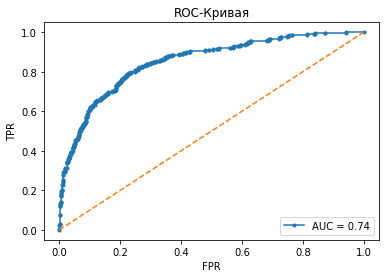



--------------------------------------------------------------

Тестирование модели "Лес решений" на данных без RowNumber, CustomerID, Surname upsampled

Значение меры accuracy =  0.7982407916437603
Значение меры recall =  0.6910569105691057
Значение меры precision =  0.5019685039370079
Значение меры f1 =  0.5815279361459521
Значение меры auc roc =  0.758287075974208
Значение меры confusion matrix: 
[[1197  253]
 [ 114  255]]


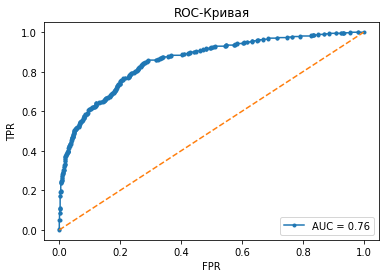



--------------------------------------------------------------


In [25]:
#Протестируем выбранную модель на полных данных:
print()
print('Тестирование модели "Лес решений" на полных данных upsampled')
print()
test_prdict_HO = ForestChurn_HO_ups.predict(churn_feat_test)
print_basic_metrics(churn_targ_test,test_prdict_HO,ForestChurn_HO_ups,churn_feat_test)
print()
print()
print('--------------------------------------------------------------')
print()
print('Тестирование модели "Лес решений" на данных без RowNumber, CustomerID, Surname upsampled')
print()
test_RnCi_prdict_HO = ForestChurn_RnCi_HO_ups.predict(churn_RnCi_feat_test)
print_basic_metrics(churn_RnCi_targ_test,test_RnCi_prdict_HO,ForestChurn_RnCi_HO_ups,churn_RnCi_feat_test)
print()
print()
print('--------------------------------------------------------------')

На тестовой выборке результирующие метрики оказались близки к значениям на валидационной выборке
<b>Модель на полных данных:</b>
<table>
    <tr><td>Метрика</td><td>валидационная выборка</td><td>Тестовая выборка</td></tr>
    <tr><td>accuracy</td><td>0.8443344334433444</td><td>0.8416712479384277</td></tr>
    <tr><td>recall</td><td>0.5655737704918032</td><td>0.5745257452574526</td></tr>
    <tr><td>precision</td><td> 0.6253776435045317</td><td>0.6180758017492711</td></tr>
    <tr><td>f1</td><td> 0.593974175035868</td><td>0.5955056179775281</td></tr>
    <tr><td>auc roc</td><td>0.7400871607279953</td><td>0.736694701429773</td></tr>
</table>
На тестовой выборке на модели на полных данных значение параметра  f1 оказалось немного больше, чем на валидационной. Однако значения auc roc и precision оказались немного меньше. Это говорит о том, что на тестовой выборке мы получили чуть больше False Positive предсказаний. в целом качество модели достаточно выское
<b>Модель на данных без RowNumber, CustomerID, Surname:</b>
<table>
    <tr>
		<td>метрика</td>
		<td>валидационная выборка</td>
		<td>тестовая выборка</td>
	</tr>
	<tr>
		<td>accuracy</td>
		<td>0.8168316831683168</td>
		<td>0.7982407916437603</td>
	</tr>
	<tr>
		<td>recall</td>
		<td>0.7021857923497268</td>
		<td>0.6910569105691057</td>
	</tr>
	<tr>
		<td>precision</td>
		<td>0.5343035343035343</td>
		<td>0.5019685039370079</td>
	</tr>
	<tr>
		<td>f1</td>
		<td>0.6068476977567886</td>
		<td>0.5815279361459521</td>
	</tr>
	<tr>
		<td>auc roc</td>
		<td>0.7739579099489681</td>
		<td>0.758287075974208</td>
	</tr>
</table>
На тестовой выборке на модели на данных без RowNumber, CustomerID, Surname значение всех метрик оказалось ниже, чем на валидационной. Возможно, у полученной модели есть некоторая склонность к переобучению, хотя разница в показателях на тестовой и валидационной выборках заметна. 